In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Loading the data
file_path = file_path = 'C:/Users/gaurav/Downloads/Documents/Machine Learning-Project/Data.xlsx'
df = pd.read_excel(file_path, sheet_name='Samples')

# Select relevant columns and preprocess
df['Date-Time'] = pd.to_datetime(df['Date-Time'])
df = df.sort_values('Date-Time')
df.set_index('Date-Time', inplace=True)
data = df[['Reactor Temperature', 'Agitation', 'Solution Concentration', 'Volume']]

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create time-series sequences
def create_sequences(data, target_index, seq_length=10):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, target_index])
    return np.array(X), np.array(y)

# Prepare sequences
seq_length = 10
target_index = 0  # 'Reactor Temperature'
X, y = create_sequences(scaled_data, target_index, seq_length)

# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape X for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], seq_length, X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], seq_length, X_test.shape[2]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")

# Optional: Save the model
model.save('lstm_temperature_prediction_model.h5')

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
107/110 [============================>.] - ETA: 0s - loss: 0.0532WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000020DCB0C4CA8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the fu

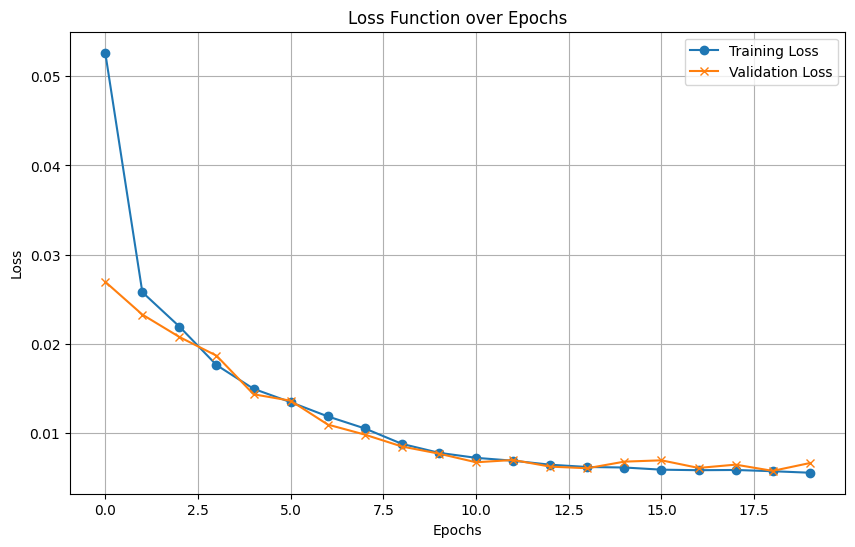

In [13]:
import matplotlib.pyplot as plt

# Check if the 'history' object is available
if 'history' in locals() or 'history' in globals():
    # Extract loss values
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot the loss values
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label="Training Loss", marker='o')
    plt.plot(val_loss, label="Validation Loss", marker='x')
    plt.title("Loss Function over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Error: 'history' object not found. Ensure the model has been trained before running this script.")


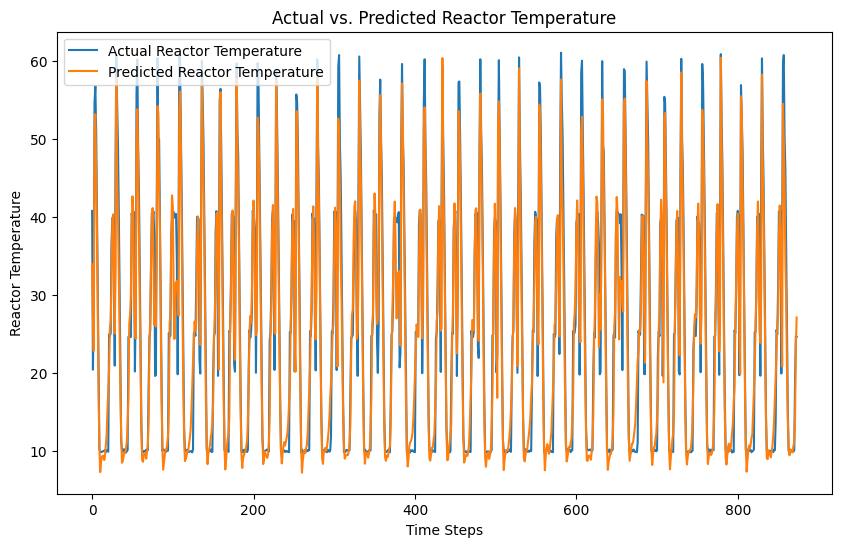

In [15]:
import matplotlib.pyplot as plt

# Generate predictions on the test set
predicted_temperature = model.predict(X_test)

# Rescale the data back to original range
y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data.shape[1]-1))), axis=1))[:, 0]
predicted_rescaled = scaler.inverse_transform(np.concatenate((predicted_temperature, np.zeros((predicted_temperature.shape[0], data.shape[1]-1))), axis=1))[:, 0]

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label="Actual Reactor Temperature")
plt.plot(predicted_rescaled, label="Predicted Reactor Temperature")
plt.title("Actual vs. Predicted Reactor Temperature")
plt.xlabel("Time Steps")
plt.ylabel("Reactor Temperature")
plt.legend()
plt.show()


In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Function to create time-series sequences
def create_sequences(data, target_index, seq_length=10):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, target_index])
    return np.array(X), np.array(y)

# Evaluate each feature independently
feature_importance = {}
for i, feature in enumerate(data.columns):
    # Prepare the data for the current feature
    feature_data = data[[feature, 'Reactor Temperature']]  # Current feature + target
    scaled_feature_data = scaler.fit_transform(feature_data)
    X_feature, y_feature = create_sequences(scaled_feature_data, target_index=1, seq_length=10)

    # Split into training and test sets
    train_size = int(len(X_feature) * 0.8)
    X_train, X_test = X_feature[:train_size], X_feature[train_size:]
    y_train, y_test = y_feature[:train_size], y_feature[train_size:]

    # Reshape X for LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], 10, 2))
    X_test = np.reshape(X_test, (X_test.shape[0], 10, 2))

    # Build and train the model
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(10, 2)),
        LSTM(units=50, return_sequences=False),
        Dense(units=25),
        Dense(units=1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Evaluate the model
    loss = model.evaluate(X_test, y_test, verbose=0)
    feature_importance[feature] = loss

# Display feature importance
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1])
print("Feature Importance (lower loss = more important):")
for feature, loss in sorted_importance:
    print(f"{feature}: {loss:.4f}")


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Generate predictions on the test set
predicted_temperature = model.predict(X_test)

# Rescale the predictions and actual values back to their original scale
y_test_rescaled = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1))), axis=1)
)[:, 0]
predicted_rescaled = scaler.inverse_transform(
    np.concatenate((predicted_temperature, np.zeros((predicted_temperature.shape[0], X_test.shape[2] - 1))), axis=1)
)[:, 0]

# Calculate evaluation metrics
mse = mean_squared_error(y_test_rescaled, predicted_rescaled)
mae = mean_absolute_error(y_test_rescaled, predicted_rescaled)
r2 = r2_score(y_test_rescaled, predicted_rescaled)

# Display the results
print("Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model Evaluation Metrics:
Mean Squared Error (MSE): 93739.5341
Mean Absolute Error (MAE): 218.1446
R-squared (R²): 0.8985
